In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import torch
print(torch.__version__)
from rdkit import Chem
from rdkit.Chem.rdchem import BondType as BT
import torch.nn.functional as F
from torch_sparse import coalesce
from torch_geometric.data import Data
import os
import numpy as np
from torch_geometric.utils import to_dense_adj
from rdkit.Chem import Draw
import networkx as nx
from torch.utils.data import DataLoader, Dataset


2.0.1


In [3]:
def mols_from_file(pathfile: str, drop_none: bool = False):
    '''
    takes as input a path/to/file.ext 
    where ext can be:
    .sdf, .csv, .txt, .smiles
    it returns all mols from file
    if drop_none: drops all mols non valid for rdkit
    '''
    filename_ext = os.path.splitext(pathfile)[-1].lower()
    if filename_ext in ['.sdf']:
        suppl = Chem.SDMolSupplier(pathfile)
    elif filename_ext in ['.csv', '.txt', '.smiles']:
        suppl = Chem.SmilesMolSupplier(pathfile, titleLine=False)
    else:
        raise TypeError(f"{filename_ext} not supported")
    if drop_none:
        return [x for x in suppl if x is not None]
    return [x for x in suppl]

In [24]:
# guacm_smiles = "/home/nobilm@usi.ch/master_thesis/guacamol/guacamol2_molgpt.smiles"
guacm_smiles = "/home/nobilm@usi.ch/master_thesis/guacamol/testdata.smiles"
guac_mols = mols_from_file(guacm_smiles, True)

[09:48:03] WARNING: no name column found on line 0
[09:48:03] WARNING: no name column found on line 1
[09:48:03] WARNING: no name column found on line 2
[09:48:03] WARNING: no name column found on line 3
[09:48:03] WARNING: no name column found on line 4
[09:48:03] WARNING: no name column found on line 5
[09:48:03] WARNING: no name column found on line 6
[09:48:03] WARNING: no name column found on line 7
[09:48:03] WARNING: no name column found on line 8
[09:48:03] WARNING: no name column found on line 9
[09:48:03] WARNING: no name column found on line 10
[09:48:03] WARNING: no name column found on line 11
[09:48:03] WARNING: no name column found on line 12
[09:48:03] WARNING: no name column found on line 13
[09:48:03] WARNING: no name column found on line 14
[09:48:03] WARNING: no name column found on line 15
[09:48:03] WARNING: no name column found on line 16
[09:48:03] WARNING: no name column found on line 17
[09:48:03] WARNING: no name column found on line 18
[09:48:03] WARNING: no

In [25]:
len(guac_mols)

14962

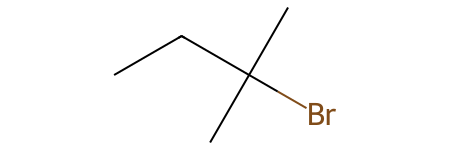

In [5]:
guac_mols[0]

In [6]:
Chem.MolToSmiles(guac_mols[0]); # CCC(C)(C)Br

'CCC(C)(C)Br'

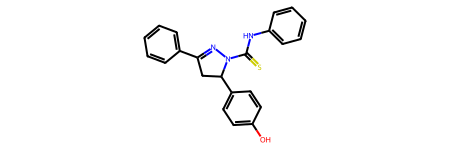

In [7]:
guac_mols[2]

In [10]:
Chem.MolToSmiles(guac_mols[2])

'Oc1ccc(C2CC(c3ccccc3)=NN2C(=S)Nc2ccccc2)cc1'

In [27]:
from collections import Counter

c = Counter()
def get_atoms_info(mols):
    atoms = set()
    max_num = 0
    for num_mol, m in enumerate(mols):
        if m.GetNumAtoms() > max_num: max_num = m.GetNumAtoms()

        atom_types = [atom.GetSymbol() for atom in m.GetAtoms()]
        c.update(atom_types)
        
        for atom in atom_types:
            atoms.add(atom)
        
    atom2num = {}

    for i, atomType in enumerate(atoms):
        atom2num[str(atomType)] = i

    num2atom = {v:k for k,v in atom2num.items()}
    print("TOTAL NUM OF MOLS: ", num_mol)
    return atom2num, num2atom, max_num

In [28]:
# def get_dicts(mols):
#     atoms, bonds = set(), set()
#     for m in mols:
#         # for b in m.GetBonds():
#         #     bonds.add(b.GetBondType())    
#     bond2num = {}    
#     # for i, bondType in enumerate(bonds):
#     #     bond2num[str(bondType)] = i
#     # num2bond = {v:k for k,v in bond2num.items()}

In [29]:
atom2num, num2atom, max_num = get_atoms_info(guac_mols)

TOTAL NUM OF MOLS:  14961


In [30]:
c

Counter({'C': 308747,
         'N': 46253,
         'O': 45929,
         'S': 5995,
         'F': 5699,
         'Cl': 3481,
         'Br': 712,
         'P': 265,
         'I': 100,
         'B': 24,
         'Si': 22,
         'Se': 12})

In [31]:
atom2num, max_num

({'Cl': 0,
  'F': 1,
  'P': 2,
  'I': 3,
  'B': 4,
  'O': 5,
  'Br': 6,
  'N': 7,
  'Si': 8,
  'C': 9,
  'S': 10,
  'Se': 11},
 66)

In [32]:
bond2num = {BT.SINGLE: 0, BT.DOUBLE: 1, BT.TRIPLE: 2, BT.AROMATIC: 3}
num2bond = {v:k for k,v in bond2num.items()}

In [33]:
#! TODO: multiprocess
def rdkit2pyg(mols):
    '''
    :param mols: iterable of rdkit mols
    :return: list of PyG data objs with one-hot node/edge features
    '''
    data_list = []
    for mol in mols:
        if mol is None:
            continue

        N = mol.GetNumAtoms()

        type_idx = []
        for atom in mol.GetAtoms():
            type_idx.append(atom2num[atom.GetSymbol()])

        x = F.one_hot(torch.tensor(type_idx), num_classes=len(atom2num))
        row, col, bond_idx = [], [], []
        for bond in mol.GetBonds():
            start, end = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
            row += [start, end]
            col += [end, start]
            bond_idx += 2 * [bond2num[bond.GetBondType()]]

        edge_index = torch.tensor([row, col], dtype=torch.long)
        edge_attr = F.one_hot(torch.tensor(bond_idx).to(torch.int64),
                              num_classes=len(bond2num)).to(torch.float)
        edge_index, edge_attr = coalesce(edge_index, edge_attr, N, N)

        data_list.append(Data(x=x, edge_index=edge_index, edge_attr=edge_attr))

    return data_list

In [34]:
data = rdkit2pyg(guac_mols[:5])

In [35]:
def pyg2rdkit(dataset):
    def numpy_to_rdkit(adj, nf, ef, sanitize=False):
        """
        Converts a molecule from numpy to RDKit format.
        :param adj: binary numpy array of shape (N, N) 
        :param nf: numpy array of shape (N, F)
        :param ef: numpy array of shape (N, N, S)
        :param sanitize: whether to sanitize the molecule after conversion
        :return: an RDKit molecule
        """
        if Chem is None:
            raise ImportError('`numpy_to_rdkit` requires RDKit.')
        mol = Chem.RWMol()
        for nf_ in nf:
            # atomic_num = torch.argmax(nf_).item()
            atomic_num = int(nf_)
            mol.AddAtom(Chem.Atom(num2atom[atomic_num]))

        for i, j in zip(*np.triu_indices(adj.shape[-1])):
            if i != j and adj[i, j] == adj[j, i] == 1 and not mol.GetBondBetweenAtoms(int(i), int(j)):
                bond_type_1 = num2bond[int(ef[i, j, 0])]
                bond_type_2 = num2bond[int(ef[j, i, 0])]
                if bond_type_1 == bond_type_2:
                    mol.AddBond(int(i), int(j), bond_type_1)

        mol = mol.GetMol()
        if sanitize: Chem.SanitizeMol(mol)
        return mol

    mols_ = []
    for i, obs in enumerate(dataset):
        ef_temp = torch.squeeze(to_dense_adj(edge_index=obs.edge_index, batch=None, edge_attr=obs.edge_attr), 0)
        ef = torch.zeros((ef_temp.shape[0], ef_temp.shape[1], 1))
        adj = torch.zeros((ef_temp.shape[0], ef_temp.shape[1]))
        
        for row in range(ef_temp.shape[0]):
            for col in range(ef_temp.shape[1]):
                if int(torch.sum(ef_temp[row, col]).item()) != 0:
                    ef[row, col, 0] = torch.argmax(ef_temp[row, col]).item()
                    adj[row, col] = 1

        ef = np.array(ef)
        adj = np.array(adj)

        adj = adj.astype(int)
        ef = ef.astype(int)

        nf = np.array([torch.argmax(row).item() for row in obs.x])
        nf = np.expand_dims(nf, 1)
        nf = nf.astype(int)
        mols_.append(numpy_to_rdkit(adj, nf, ef))

    return mols_

In [36]:
decoded_data = pyg2rdkit(data)

/tmp/ipykernel_1637056/1041621057.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  atomic_num = int(nf_)


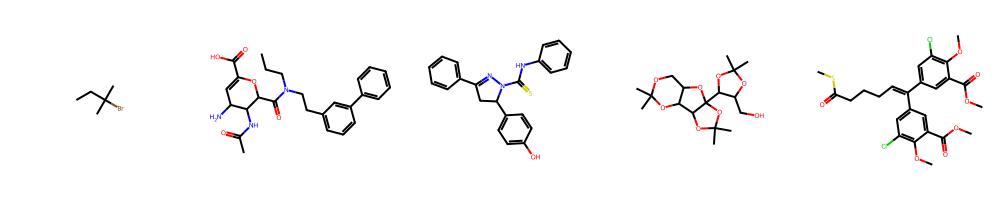

In [37]:
Draw.MolsToGridImage(guac_mols[:5], molsPerRow=5)

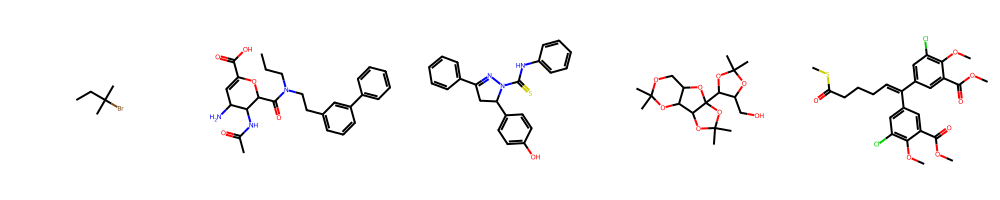

In [38]:
Draw.MolsToGridImage(decoded_data, molsPerRow=5)

In [39]:
data = rdkit2pyg(guac_mols[:100])

In [40]:
len(data)

100

# Data pipeline

In [41]:
from utils.data_utils import  to_undirected, encode_adj

class Graph_sequence_sampler_pytorch(torch.utils.data.Dataset):
    '''
    returns : dictionary containing input/output nodes, input/output edges
    '''

    def __init__(self, Graph_list, node_attr_list, adj_all, max_num_node, max_prev_node):

        '''
        Graph_list: list of undirected networkx graphs
        node_attr_list: list of node matrices
        adj_all: list of A(s) with edge features as elements a_ij [NxNxEf]
        max_num_node : max number of possible nodes in a graph
        max_prev_node : max previous node that looks back (to lock back at)
        '''

        self.adj_all = adj_all  # list of multidim np.arrays (As) already in edge_feature form [V, V , node_f]
        self.len_all = []  # V for each G
        self.node_attr_list = node_attr_list
        self.graph_list = Graph_list  # list of undirected nx graphs
        for G in Graph_list:
            self.len_all.append(G.number_of_nodes())  # timesteps of node rnn for each G
        self.max_num_node = max_num_node
        self.max_prev_node = max_prev_node

        self.edge_feature_dims = 5
        self.node_feature_dims = 12

    def __len__(self):
        return len(self.adj_all)

    def __getitem__(self, idx):
        # edge encoding:
        adj_copy = np.asarray(self.adj_all[idx]).copy()
        adj_copy = np.squeeze(adj_copy)  # adj_copy had bs as first dim
        x_batch = np.zeros((self.max_num_node, self.max_prev_node, self.edge_feature_dims))
        y_batch = np.zeros((self.max_num_node, self.max_prev_node, self.edge_feature_dims))

        original_a = np.asarray(nx.adjacency_matrix(self.graph_list[idx]).todense())  # A without edge features of the current g
        # original_a = np.asarray(nx.from_numpy_array(self.graph_list[idx]))  # A without edge features of the current g
        adj_encoded = encode_adj(adj=adj_copy, original=original_a, max_prev_node=self.max_prev_node, edge_feature_dims = self.edge_feature_dims)

        x_batch[0, :, :] = 1
        x_batch[1:adj_encoded.shape[0] + 1, :] = adj_encoded
        y_batch[0:adj_encoded.shape[0], :] = adj_encoded

        for r in range(y_batch.shape[0]):
            for c in range(y_batch.shape[1]):
                if np.sum(y_batch[r, c, :]) == 0:
                    y_batch[r, c, 0] = 1

        # node encoding:
        node_attr_list_copy = np.asarray(self.node_attr_list[idx]).copy()
        x_node_attr = np.zeros((self.max_num_node, self.node_feature_dims))
        y_node_attr = np.zeros((self.max_num_node, self.node_feature_dims))

        # input nodes:
        x_node_attr[0, :] = 1
        x_node_attr[1:node_attr_list_copy.shape[0], :] = node_attr_list_copy[:-1]

        # output nodes:
        y_node_attr[:node_attr_list_copy.shape[0], :] = node_attr_list_copy

        len_batch = node_attr_list_copy.shape[0]  # number of nodes of current g

        return {'x': x_batch, 'y': y_batch, 'len': len_batch, 'x_node_attr': x_node_attr, 'y_node_attr': y_node_attr}

In [ ]:
from torch_geometric.utils import to_networkx


def process_subset(subset, max_num_node, max_prev_node):
    '''
    :param subset: dataset for training or dataset for testing
    :param max_num_node: max num of nodes in the set of graphs
    :param max_prev_node: max_num_node - 1
    :return: Graph_sequence_sampler_pytorch data object
    '''

    G_list = []  # list of undirected networkx graphs
    node_attr_list = [] # list of node matrices
    for g in subset:
        node_attr_list.append(g.x)  # node matrix
        nxG = to_networkx(g)
        G_list.append(to_undirected(nxG))

    adj_all = []  # list of A(s) with edge features as elements a_ij [NxNxEf]
    for g in subset:
        adj_all.append(to_dense_adj(edge_index=g.edge_index, batch=None, edge_attr=g.edge_attr))

    return Graph_sequence_sampler_pytorch(Graph_list=G_list, node_attr_list=node_attr_list, adj_all=adj_all,
                                          max_num_node=max_num_node, max_prev_node=max_prev_node)

def create_train_val_dataloaders(dataset, max_num_node, max_prev_node):
    '''
    for supervised training takes as input:
    - dataset: a list of pyg Data obs,
    - max number of nodes of the loaded graphs,
    - max_prev_node = (max number of nodes-1)
    '''
    train_set = process_subset(dataset, max_num_node, max_prev_node)
    train_dataset_loader = DataLoader(train_set, batch_size=32, shuffle=True)#, num_workers=15)
    return train_dataset_loader, []

In [18]:
# from supervised_tools.create_train_val_data import create_train_val_dataloaders
train_dataset_loader, _ = create_train_val_dataloaders(data, max_num, max_num-1)

In [ ]:
def bfs_seq(G, start_id):
    '''
    get a bfs node sequence
    :param G:
    :param start_id:
    :return:
    '''
    dictionary = dict(nx.bfs_successors(G, start_id))
    start = [start_id]
    output = [start_id]
    while len(start) > 0:
        next = []
        while len(start) > 0:
            current = start.pop(0)
            neighbor = dictionary.get(current)
            if neighbor is not None:
                #### a wrong example, should not permute here!
                # shuffle(neighbor)
                next = next + neighbor
        output = output + next
        start = next
    return output
